In [1]:
import dash
# import dash_auth
# from users import USERNAME_PASSWORD_PAIRS
from dash import dcc
from dash import html
import plotly
import dash_bootstrap_components as dbc
# import dash_daq as dq
from jupyter_dash import JupyterDash
from dash import Dash
import pandas as pd  
import joblib
import base64, io, os
from dash import  dash_table
import dash
import pandas as pd
from dash import dash_table
import pickle
from dash.dependencies import Input, Output, State, ALL, MATCH
import json
# from functools import reduce
from dash import Input, Output, State, html
from tqdm.notebook import trange, tqdm
import pickle
import numpy as np
import pandas as pd
# from cryptography.fernet import Fernet
import json
import io, base64, os
import pandas as pd
import datetime
import time
import re
import plotly.express as px
import plotly.graph_objects as go

import geopandas
import tifffile as tiff
import cv2
import matplotlib; matplotlib.rcParams['figure.dpi']=300
import matplotlib.pyplot as plt
import pickle
import numpy as np
from pathpretrain.utils import generate_tissue_mask
import scipy.ndimage as ndimage
from skimage.util import compare_images
from skimage.measure import regionprops_table
from skimage import exposure
import tempfile
import matplotlib.image as mpimg

In [2]:
with open("./data/match_dict.pkl", "rb") as file:
    match_dict = pickle.load(file)

annotation_data = geopandas.read_file("./data/_SS12251_140745.geojson")
im_large = tiff.imread("./data/_SS12251_140745.svs")
im_small = cv2.resize(im_large, None, fx=1/15, fy=1/15)

with open("./data/011320_002_N_HR_dict.pkl", "rb") as input_file:
    metal_data = pickle.load(input_file)

In [3]:
im_medium = cv2.resize(im_large, None, fx=1/7, fy=1/7)

In [4]:
im_small.shape

(3101, 4657, 3)

In [5]:
metal_data['metals']['Ca44'].shape

(871, 1499)

In [6]:
def crop_slide(image_array):
#     slide_file = list(filter(lambda x: match_dict[x] == imageId, match_dict))[0]    
    im_large=image_array#tifffile.imread(f"/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/metals/breast/new_slide_images_4_6_23/{slide_file}.svs")

    tissue_mask=generate_tissue_mask(im_large*5,compression=32.,threshold=240,kernel=10,gray_before_close=True) 
    compression=32
    
    # Metal image is only portion of slide
#     if (imageId == "092619_007_T_HER2"):    
        
#     if (imageId == "102720_003_T_TNBC"):
#         labels_small=ndimage.label(cv2.resize(tissue_mask.astype(np.uint8),None,fx=1/compression,fy=1/compression,interpolation=cv2.INTER_NEAREST))[0]
#         lbl_table=pd.DataFrame(regionprops_table(labels_small,properties=['bbox','area',"label"])).sort_values("area",ascending=False)
#         xmin,ymin,xmax,ymax=(lbl_table.iloc[1][[col for col in lbl_table if "bbox" in col]]*compression).astype(int)   
#     else:  
    labels_small=ndimage.label(cv2.resize(tissue_mask.astype(np.uint8),None,fx=1/compression,fy=1/compression,interpolation=cv2.INTER_NEAREST))[0]
    lbl_table=pd.DataFrame(regionprops_table(labels_small,properties=['bbox','area',"label"])).sort_values("area",ascending=False)
    xmin,ymin,xmax,ymax=(lbl_table.iloc[0][[col for col in lbl_table if "bbox" in col]]*compression).astype(int)   
    
    im_large_crop=im_large[xmin:xmax,ymin:ymax].copy()
    im_large_crop[~tissue_mask[xmin:xmax,ymin:ymax]]=255
    
    return im_large_crop, [[xmin, ymin], [xmax, ymax]], tissue_mask

In [7]:
im_large_crop, minmax_list, tissue_mask = crop_slide(im_large)
im_small_crop = cv2.resize(im_large_crop, None, fx=1/15, fy=1/15)

hne_image = px.imshow(im_small_crop)
metal_image = px.imshow(np.log(metal_data['metals']['Ca44'])+10, color_continuous_scale='jet')

/Users/luyunrui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning:

divide by zero encountered in log

/Users/luyunrui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning:

invalid value encountered in log



In [8]:
annotation_data['annot']=annotation_data['classification'].map(lambda x: x.get("name","none"))

gp2=annotation_data.copy()
gp2['geometry']=gp2['geometry'].scale(1/7,1/7,origin=(0,0))
gp2['coords'] = gp2['geometry'].apply(lambda x: x.representative_point().coords[:])
gp2['coords'] = [coords[0] for coords in gp2['coords']]

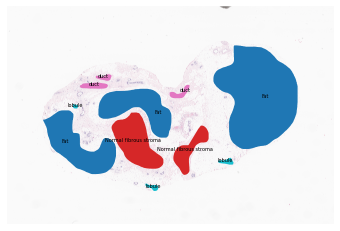

In [12]:
app = JupyterDash(__name__, 
                  external_stylesheets=[dbc.themes.SPACELAB], 
                 )

markdown_text_title = '''
# **Metals Demo**
'''

tab_Data_content = dbc.Card(
    dbc.CardBody(
        [
            html.P("This is Data tab", className="card-text"),
        ]
    ),
    className="mt-3",
)

image_no_axis_layout = go.Layout(
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
)

hne_image.update_layout(image_no_axis_layout)
metal_image.update_layout(image_no_axis_layout)
hne_image.update_layout(title=dict(text="H&E Image", x=0.5, y=0.95, xanchor='center'))

def update_metal_image(selected_metal, 
                       np_log, 
                      ):
    if np_log == 'With np log transform':
        metal_image_data = np.log(metal_data['metals'][selected_metal]) + 10
    else:
        metal_image_data = metal_data['metals'][selected_metal]
    metal_image = px.imshow(metal_image_data, color_continuous_scale='jet')
    metal_image.update_layout(image_no_axis_layout)
    metal_image.update_layout(title=dict(text="Metal Image - {}".format(selected_metal), x=0.5, y=0.95, xanchor='center'))
    return metal_image

tab_Visualization_content = dbc.Card(
    dbc.CardBody(
        [
            dbc.Row(
            [
                dbc.Col(dcc.Graph(id="hne_image", figure=hne_image, 
                                 ), 
                        width=6),
                dbc.Col(dcc.Graph(id="metal_image", figure=metal_image, 
                                 ), 
                        width=6),
            ]
        ),
            dbc.Row([
                dcc.Dropdown(
                            id='metal_dropdown',
                            options=list(metal_data['metals'].keys()),
                            value='Ca44',
                            searchable=True, 
                            style={'width': '110px'},
                                ),
                dcc.Dropdown(
                            id='np_log_dropdown',
                            options=['With np log transform', 'Without np log transform'],
                            value='With np log transform',
                            style={'width': '300px'},
                                ),
            ], justify="end",),
        ]
    ),
    className="mt-3",
)

tab_Coregister_content = dbc.Card(
    dbc.CardBody(
        [
            html.P("This is Coregister tab", className="card-text"),
        ]
    ),
    className="mt-3",
)


# gp2.plot('annot', aspect=1)
# plt.imshow(im_medium)
# plt.axis("off")
# for idx, row in gp2.iterrows():
#     plt.annotate(text=row['annot'], xy=row['coords'],
#                 horizontalalignment='center', fontsize=5, rotation=0)
# plt.savefig('books_read.png')
# canvas = plt.get_current_fig_manager().canvas
# canvas.draw()
# width, height = canvas.get_width_height()
# rgb_data = np.frombuffer(canvas.buffer_rgba(), dtype=np.uint8).reshape(height, width, 4)[:, :, :3]  # Remove alpha channel
# non_padding_pixels = np.any(rgb_data != [255, 255, 255], axis=2)
# rows = np.any(non_padding_pixels, axis=1)
# cols = np.any(non_padding_pixels, axis=0)
# top, bottom = np.where(rows)[0][[0, -1]]
# left, right = np.where(cols)[0][[0, -1]]
# im_medium_annot = rgb_data[top:bottom+1, left:right+1]

# annotations = [
#     dict(
#         x=row['coords'][0],
#         y=row['coords'][1],
#         xref='x',
#         yref='y',
#         text=row['annot'],
#         showarrow=True,
#         arrowhead=2,
#         ax=0,
#         ay=-40,
#         font=dict(size=8),
#     )
#     for _, row in gp2.iterrows()
# ]

gp2.plot('annot', aspect=1)
plt.imshow(im_medium)
plt.axis("off")
for idx, row in gp2.iterrows():
    plt.annotate(text=row['annot'], xy=row['coords'],
                horizontalalignment='center', fontsize=5, rotation=0)
# temp_image_path = os.path.join(tempfile.gettempdir(), "annotated_image.png")
plt.savefig('./annotated_image.png')
# temp_image_path = os.path.join(tempfile.gettempdir(), "annotated_image.png")
# cv2.imwrite(temp_image_path, cv2.cvtColor(im_medium, cv2.COLOR_RGB2BGR))

# annotate_graph = dcc.Graph(
#         id='annotate_image',
#         figure={
#             'data': [
#                 go.Scatter(
#                     x=[],
#                     y=[],
#                     mode='markers',
#                     marker=dict(size=5),
#                 ),
#             ],
#             'layout': go.Layout(
#                 images=[{
#                     'source': temp_image_path,
#                     'xref': 'x',
#                     'yref': 'y',
#                     'x': 0,
#                     'y': 0,
#                     'sizex': im_medium.shape[1],
#                     'sizey': im_medium.shape[0],
#                     'sizing': 'stretch',
#                     'layer': 'below',
#                 }],
#                 annotations=annotations,
#                 xaxis=dict(range=[0, im_medium.shape[1]], visible=False, 
#                            showgrid=False, zeroline=False, showticklabels=False),
#                 yaxis=dict(range=[0, im_medium.shape[0]], visible=False, 
#                            showgrid=False, zeroline=False, showticklabels=False),
#                 title=dict(text="H&E Annotated Image", x=0.5, y=0.95, xanchor='center')
#             ),
#         }
#     )
im_medium_annot = mpimg.imread('./annotated_image.png')
os.remove('./annotated_image.png')
original_image = px.imshow(im_medium)
annotate_image = px.imshow(im_medium_annot)

original_image.update_layout(image_no_axis_layout)
annotate_image.update_layout(image_no_axis_layout)

original_image.update_layout(title=dict(text="H&E Image", x=0.5, y=0.95, xanchor='center'))
annotate_image.update_layout(title=dict(text="H&E Annotated Image", x=0.5, y=0.95, xanchor='center'))


two_measure_images = dbc.Row(
                        [dbc.Row(
                                [
                                    dbc.Col(dcc.Graph(figure=original_image), width=6),
                                    dbc.Col(dcc.Graph(figure=annotate_image), width=6),
                                    ]
)])

tab_Measure_content = dbc.Card(
    dbc.CardBody(
        [
            two_measure_images,
        ]
    ),
    className="mt-3",
)

all_tabs = dbc.Tabs(
    [
        dbc.Tab(tab_Data_content, label="Data"),
        dbc.Tab(tab_Visualization_content, label="Visualization"),
        dbc.Tab(tab_Coregister_content, label="Co-register"),
        dbc.Tab(tab_Measure_content, label="Measure"),
    ]
)

app.layout = html.Div([dcc.Markdown(children=markdown_text_title),
                       all_tabs])

@app.callback(
    Output('metal_image', 'figure'),
    [Input('metal_dropdown', 'value'), 
     Input('np_log_dropdown', 'value')]
)

def update_metal_image_callback(selected_metal, np_log):
    return update_metal_image(selected_metal, np_log)










In [13]:
app.run_server(debug=False,
               mode="external",
               host='localhost', 
              )

 * Running on http://localhost:8050 (Press CTRL+C to quit)
127.0.0.1 - - [28/Jul/2023 16:46:03] "GET /_alive_bea89666-c2eb-4c0f-b6e5-1d66115d6873 HTTP/1.1" 200 -


Dash app running on http://localhost:8050/


127.0.0.1 - - [28/Jul/2023 16:46:23] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [28/Jul/2023 16:46:23] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [28/Jul/2023 16:46:24] "GET /_favicon.ico?v=2.5.0 HTTP/1.1" 200 -
127.0.0.1 - - [28/Jul/2023 16:46:25] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [28/Jul/2023 16:46:26] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 304 -
127.0.0.1 - - [28/Jul/2023 16:46:26] "GET /_dash-component-suites/dash/dcc/async-markdown.js HTTP/1.1" 304 -
127.0.0.1 - - [28/Jul/2023 16:46:26] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 304 -
/Users/luyunrui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning:

divide by zero encountered in log

/Users/luyunrui/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning:

invalid value encountered in log

127.0.0.1 - - [28/Jul/2023 16:46:26] "GET /_dash-component-suites/dash/dcc/async-dropdown.js HTTP/1.1" 304 -
127.0.0.1 - - 